# International Matches_EDA + Data Preparation & Cleaning 

Here we aim to analyze the "international_matches.csv" dataset and from it, create a training dataset and an inference dataset, which will be used to predict the results of the QATAR 2022 World Cup.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/international_matches.csv', parse_dates=['date'])
df.tail()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


In [3]:
df.columns

Index(['date', 'home_team', 'away_team', 'home_team_continent',
       'away_team_continent', 'home_team_fifa_rank', 'away_team_fifa_rank',
       'home_team_total_fifa_points', 'away_team_total_fifa_points',
       'home_team_score', 'away_team_score', 'tournament', 'city', 'country',
       'neutral_location', 'shoot_out', 'home_team_result',
       'home_team_goalkeeper_score', 'away_team_goalkeeper_score',
       'home_team_mean_defense_score', 'home_team_mean_offense_score',
       'home_team_mean_midfield_score', 'away_team_mean_defense_score',
       'away_team_mean_offense_score', 'away_team_mean_midfield_score'],
      dtype='object')

In [4]:
df.isnull().sum()

date                                 0
home_team                            0
away_team                            0
home_team_continent                  0
away_team_continent                  0
home_team_fifa_rank                  0
away_team_fifa_rank                  0
home_team_total_fifa_points          0
away_team_total_fifa_points          0
home_team_score                      0
away_team_score                      0
tournament                           0
city                                 0
country                              0
neutral_location                     0
shoot_out                            0
home_team_result                     0
home_team_goalkeeper_score       15542
away_team_goalkeeper_score       15826
home_team_mean_defense_score     16134
home_team_mean_offense_score     15411
home_team_mean_midfield_score    15759
away_team_mean_defense_score     16357
away_team_mean_offense_score     15609
away_team_mean_midfield_score    15942
dtype: int64

# PRE-ANALYSIS
The dataset has a lot of blank fields that need to be fixed.
However, before modifying any field, I want to analyze the teams' qualifications on the last FIFA date (June 2022). This is important because, from these qualifications, I will create the inference dataset that enters the machine learning algorithm that predicts the World Cup matches.

### Top 10 FIFA Ranking

In [5]:
fifa_rank = df[['date','home_team', 'away_team', 'home_team_fifa_rank', 'away_team_fifa_rank']]
home = fifa_rank[['date', 'home_team', 'home_team_fifa_rank']].rename(columns={"home_team":"team", "home_team_fifa_rank":"rank"})
away = fifa_rank[['date', 'away_team', 'away_team_fifa_rank']].rename(columns={"away_team":"team", "away_team_fifa_rank":"rank"})
fifa_rank = pd.concat([home, away])
#Select each country latest match
fifa_rank = fifa_rank.sort_values(['team', 'date'], ascending=[True, False])
last_rank = fifa_rank
fifa_rank_top10 = fifa_rank.groupby('team').first().sort_values('rank', ascending=True)[0:10].reset_index()
fifa_rank_top10

,team,date,rank
0,Brazil,2022-06-06,1
1,Belgium,2022-06-14,2
2,France,2022-06-13,3
3,Argentina,2022-06-05,4
4,England,2022-06-14,5
5,Italy,2022-06-14,6
6,Spain,2022-06-12,7
7,Portugal,2022-06-12,8
8,Mexico,2022-06-14,9
9,Netherlands,2022-06-14,10


### Top 10 teams with the highest winning percentage at home and away

In [6]:
def home_percentage(team):
    score = len(df[(df['home_team'] == team) & (df['home_team_result'] == "Win")]) / len(df[df['home_team'] == team]) * 100
    return round(score)
def away_percentage(team):
    score = len(df[(df['away_team'] == team) & (df['home_team_result'] == "Lose")]) / len(df[df['away_team'] == team]) * 100
    return round(score)

In [7]:
fifa_rank_top10['Home_win_Per'] = np.vectorize(home_percentage)(fifa_rank_top10['team'])
fifa_rank_top10['Away_win_Per'] = np.vectorize(away_percentage)(fifa_rank_top10['team'])
fifa_rank_top10['Average_win_Per'] = round((fifa_rank_top10['Home_win_Per'] + fifa_rank_top10['Away_win_Per']) / 2)
fifa_rank_win = fifa_rank_top10.sort_values('Average_win_Per', ascending = False)
fifa_rank_win

,team,date,rank,Home_win_Per,Away_win_Per,Average_win_Per
0,Brazil,2022-06-06,1,78,60,69.0
6,Spain,2022-06-12,7,77,61,69.0
2,France,2022-06-13,3,66,57,62.0
3,Argentina,2022-06-05,4,68,49,58.0
4,England,2022-06-14,5,64,51,58.0
7,Portugal,2022-06-12,8,67,49,58.0
9,Netherlands,2022-06-14,10,62,55,58.0
5,Italy,2022-06-14,6,60,49,54.0
1,Belgium,2022-06-14,2,60,46,53.0
8,Mexico,2022-06-14,9,60,41,50.0


### Top 10 attacking teams in the last FIFA date

In [8]:
fifa_offense = df[['date', 'home_team', 'away_team', 'home_team_mean_offense_score', 'away_team_mean_offense_score']]
home = fifa_offense[['date', 'home_team', 'home_team_mean_offense_score']].rename(columns={"home_team":"team", "home_team_mean_offense_score":"offense_score"})
away = fifa_offense[['date', 'away_team', 'away_team_mean_offense_score']].rename(columns={"away_team":"team", "away_team_mean_offense_score":"offense_score"})
fifa_offense = pd.concat([home, away])
fifa_offense = fifa_offense.sort_values(['date', 'team'],ascending=[False, True])
last_offense = fifa_offense
fifa_offense_top10 = fifa_offense.groupby('team').first().sort_values('offense_score', ascending=False)[0:10].reset_index()
fifa_offense_top10

,team,date,offense_score
0,Argentina,2022-06-05,89.0
1,France,2022-06-13,88.3
2,England,2022-06-14,88.0
3,Brazil,2022-06-06,86.3
4,Portugal,2022-06-12,86.0
5,Belgium,2022-06-14,85.7
6,Italy,2022-06-14,85.3
7,Spain,2022-06-12,85.0
8,Poland,2022-06-14,84.7
9,Uruguay,2022-06-11,84.3


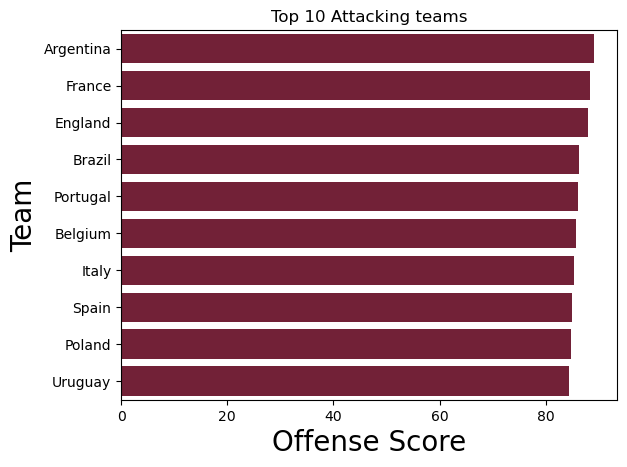

In [9]:
sns.barplot(data=fifa_offense_top10, x='offense_score', y='team', color="#7F1431")
plt.xlabel('Offense Score', size = 20) 
plt.ylabel('Team', size = 20) 
plt.title("Top 10 Attacking teams");

### Top 10 Midfield teams in the last FIFA date

In [10]:
fifa_midfield = df[['date', 'home_team', 'away_team', 'home_team_mean_midfield_score', 'away_team_mean_midfield_score']]
home = fifa_midfield[['date', 'home_team', 'home_team_mean_midfield_score']].rename(columns={"home_team":"team", "home_team_mean_midfield_score":"midfield_score"})
away = fifa_midfield[['date', 'away_team', 'away_team_mean_midfield_score']].rename(columns={"away_team":"team", "away_team_mean_midfield_score":"midfield_score"})
fifa_midfield = pd.concat([home,away])
fifa_midfield = fifa_midfield.sort_values(['date','team'],ascending=[False,True])
last_midfield = fifa_midfield
fifa_midfield_top10 = fifa_midfield.groupby('team').first().sort_values('midfield_score',ascending=False)[0:10].reset_index()
fifa_midfield_top10

,team,date,midfield_score
0,Germany,2022-06-14,87.8
1,France,2022-06-13,86.8
2,Spain,2022-06-12,86.0
3,Belgium,2022-06-14,85.5
4,Brazil,2022-06-06,85.5
5,Portugal,2022-06-12,84.5
6,Italy,2022-06-14,84.5
7,Croatia,2022-06-13,84.2
8,England,2022-06-14,84.0
9,Argentina,2022-06-05,84.0


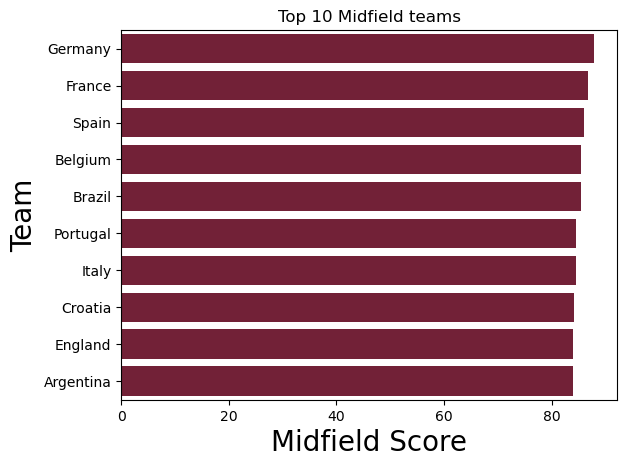

In [11]:
sns.barplot(data=fifa_midfield_top10, x='midfield_score', y='team', color="#7F1431")
plt.xlabel('Midfield Score', size = 20) 
plt.ylabel('Team', size = 20) 
plt.title("Top 10 Midfield teams");

### Top 10 defending teams in the last FIFA date

In [12]:
fifa_defense = df[['date', 'home_team', 'away_team', 'home_team_mean_defense_score', 'away_team_mean_defense_score']]
home = fifa_defense[['date', 'home_team', 'home_team_mean_defense_score']].rename(columns={"home_team":"team", "home_team_mean_defense_score":"defense_score"})
away = fifa_defense[['date', 'away_team', 'away_team_mean_defense_score']].rename(columns={"away_team":"team", "away_team_mean_defense_score":"defense_score"})
fifa_defense = pd.concat([home, away])
fifa_defense = fifa_defense.sort_values(['date', 'team'],ascending=[False, True])
last_defense = fifa_defense 
fifa_defense_top10 = fifa_defense.groupby('team').first().sort_values('defense_score', ascending = False)[0:10].reset_index()
fifa_defense_top10

,team,date,defense_score
0,Spain,2022-06-12,86.5
1,Portugal,2022-06-12,85.2
2,Netherlands,2022-06-14,85.2
3,England,2022-06-14,85.0
4,Brazil,2022-06-06,84.8
5,Italy,2022-06-14,84.2
6,France,2022-06-13,84.2
7,Germany,2022-06-14,84.0
8,Argentina,2022-06-05,82.2
9,Uruguay,2022-06-11,81.2


Text(0.5, 1.0, 'Top 10 Defense Teams')

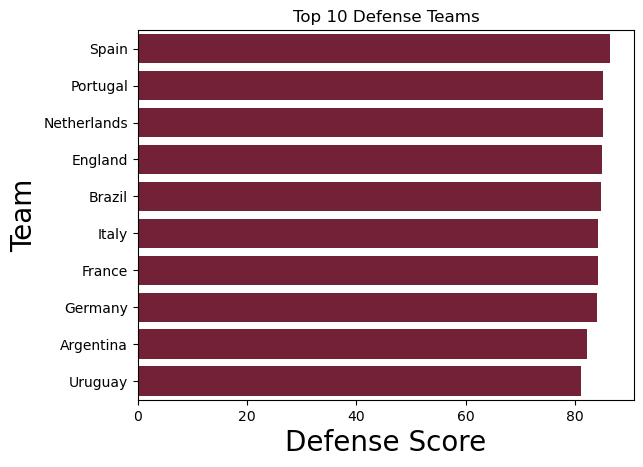

In [13]:
sns.barplot(data = fifa_defense_top10, x='defense_score', y='team', color="#7F1431")
plt.xlabel('Defense Score', size = 20) 
plt.ylabel('Team', size = 20) 
plt.title("Top 10 Defense Teams")

# DATA PREPARATION AND FEATURE ENGINEERING
In this section, we will fill in the empty fields in the dataset and clean up the data for teams that did not qualify for the World Cup. Finally, we will use the ratings of the teams in their last match to define the "Last Team Scores" dataset (i.e., the dataset that we will use to predict the World Cup matches).

### Analyze and fill na's

In [14]:
df.isnull().sum()

date                                 0
home_team                            0
away_team                            0
home_team_continent                  0
away_team_continent                  0
home_team_fifa_rank                  0
away_team_fifa_rank                  0
home_team_total_fifa_points          0
away_team_total_fifa_points          0
home_team_score                      0
away_team_score                      0
tournament                           0
city                                 0
country                              0
neutral_location                     0
shoot_out                            0
home_team_result                     0
home_team_goalkeeper_score       15542
away_team_goalkeeper_score       15826
home_team_mean_defense_score     16134
home_team_mean_offense_score     15411
home_team_mean_midfield_score    15759
away_team_mean_defense_score     16357
away_team_mean_offense_score     15609
away_team_mean_midfield_score    15942
dtype: int64

In [15]:
# We can fill mean for na's in goal_keeper_score
df[df['home_team'] == "Brazil"]['home_team_goalkeeper_score'].describe()

count    135.000000
mean      86.074074
std        3.327026
min       82.000000
25%       83.000000
50%       86.000000
75%       89.000000
max       93.000000
Name: home_team_goalkeeper_score, dtype: float64

In [16]:
df['home_team_goalkeeper_score'] = round(df.groupby("home_team")["home_team_goalkeeper_score"].transform(lambda x: x.fillna(x.mean())))
df['away_team_goalkeeper_score'] = round(df.groupby("away_team")["away_team_goalkeeper_score"].transform(lambda x: x.fillna(x.mean())))

In [17]:
# We can fill mean for na's in defense score
df[df['away_team'] == "Uruguay"]['home_team_mean_defense_score'].describe()

count    105.000000
mean      76.580000
std        5.589988
min       58.500000
25%       73.200000
50%       76.500000
75%       80.000000
max       89.500000
Name: home_team_mean_defense_score, dtype: float64

In [18]:
df['home_team_mean_defense_score'] = round(df.groupby('home_team')['home_team_mean_defense_score'].transform(lambda x : x.fillna(x.mean())))
df['away_team_mean_defense_score'] = round(df.groupby('away_team')['away_team_mean_defense_score'].transform(lambda x : x.fillna(x.mean())))

In [19]:
# We can fill mean for na's in offense score
df[df['away_team'] == "Uruguay"]['home_team_mean_offense_score'].describe()

count    117.000000
mean      78.136752
std        5.878813
min       66.700000
25%       74.000000
50%       78.000000
75%       82.300000
max       90.300000
Name: home_team_mean_offense_score, dtype: float64

In [20]:
df['home_team_mean_offense_score'] = round(df.groupby('home_team')['home_team_mean_offense_score'].transform(lambda x : x.fillna(x.mean())))
df['away_team_mean_offense_score'] = round(df.groupby('away_team')['away_team_mean_offense_score'].transform(lambda x : x.fillna(x.mean())))

In [21]:
# We can fill mean for na's in midfield score
df[df['away_team'] == "Uruguay"]['home_team_mean_midfield_score'].describe()

count    110.000000
mean      77.729091
std        5.656617
min       63.200000
25%       75.050000
50%       77.650000
75%       81.425000
max       89.500000
Name: home_team_mean_midfield_score, dtype: float64

In [22]:
df['home_team_mean_midfield_score'] = round(df.groupby('home_team')['home_team_mean_midfield_score'].transform(lambda x : x.fillna(x.mean())))
df['away_team_mean_midfield_score'] = round(df.groupby('away_team')['away_team_mean_midfield_score'].transform(lambda x : x.fillna(x.mean())))

In [23]:
df.isnull().sum()

date                                0
home_team                           0
away_team                           0
home_team_continent                 0
away_team_continent                 0
home_team_fifa_rank                 0
away_team_fifa_rank                 0
home_team_total_fifa_points         0
away_team_total_fifa_points         0
home_team_score                     0
away_team_score                     0
tournament                          0
city                                0
country                             0
neutral_location                    0
shoot_out                           0
home_team_result                    0
home_team_goalkeeper_score       5683
away_team_goalkeeper_score       6254
home_team_mean_defense_score     8019
home_team_mean_offense_score     6995
home_team_mean_midfield_score    6955
away_team_mean_defense_score     8285
away_team_mean_offense_score     7165
away_team_mean_midfield_score    7036
dtype: int64

In [24]:
# Teams are not available in FIFA game itself, so they are not less than average performing teams, so giving a average score of 50 for all.
df.fillna(50,inplace=True)

### Filter the teams participating in QATAR - World cup 2022

In [25]:
list_2022 = ['Qatar', 'Germany', 'Denmark', 'Brazil', 'France', 'Belgium', 'Croatia', 'Spain', 'Serbia', 'England', 'Switzerland', 'Netherlands', 'Argentina', 'IR Iran', 'Korea Republic', 'Japan', 'Saudi Arabia', 'Ecuador', 'Uruguay', 'Canada', 'Ghana', 'Senegal', 'Portugal', 'Poland', 'Tunisia', 'Morocco', 'Cameroon', 'USA', 'Mexico', 'Wales', 'Australia', 'Costa Rica']
final_df = df[(df["home_team"].apply(lambda x: x in list_2022)) | (df["away_team"].apply(lambda x: x in list_2022))]

**Top 10 teams in QATAR 2022**

In [26]:
rank = final_df[['date','home_team','away_team','home_team_fifa_rank', 'away_team_fifa_rank']]
home = rank[['date','home_team','home_team_fifa_rank']].rename(columns={"home_team":"team","home_team_fifa_rank":"rank"})
away = rank[['date','away_team','away_team_fifa_rank']].rename(columns={"away_team":"team","away_team_fifa_rank":"rank"})
rank = pd.concat([home,away])

# Select each country latest match
rank = rank.sort_values(['team','date'],ascending=[True,False])
rank_top10 = rank.groupby('team').first().sort_values('rank',ascending=True).reset_index()
rank_top10 = rank_top10[(rank_top10["team"].apply(lambda x: x in list_2022))][0:10]
rank_top10

,team,date,rank
0,Brazil,2022-06-06,1
1,Belgium,2022-06-14,2
2,France,2022-06-13,3
3,Argentina,2022-06-05,4
4,England,2022-06-14,5
6,Spain,2022-06-12,7
7,Portugal,2022-06-12,8
8,Mexico,2022-06-14,9
9,Netherlands,2022-06-14,10
10,Denmark,2022-06-13,11


**Top 10 teams with the highest winning percentage in QATAR 2022**

In [27]:
rank_top10['Home_win_Per'] = np.vectorize(home_percentage)(rank_top10['team'])
rank_top10['Away_win_Per'] = np.vectorize(away_percentage)(rank_top10['team'])
rank_top10['Average_win_Per'] = round((rank_top10['Home_win_Per'] + rank_top10['Away_win_Per'])/2)
rank_top10_Win = rank_top10.sort_values('Average_win_Per',ascending=False)
rank_top10_Win

,team,date,rank,Home_win_Per,Away_win_Per,Average_win_Per
0,Brazil,2022-06-06,1,78,60,69.0
6,Spain,2022-06-12,7,77,61,69.0
2,France,2022-06-13,3,66,57,62.0
3,Argentina,2022-06-05,4,68,49,58.0
4,England,2022-06-14,5,64,51,58.0
7,Portugal,2022-06-12,8,67,49,58.0
9,Netherlands,2022-06-14,10,62,55,58.0
1,Belgium,2022-06-14,2,60,46,53.0
8,Mexico,2022-06-14,9,60,41,50.0
10,Denmark,2022-06-13,11,56,45,50.0


Text(0.5, 1.0, 'Top 10 QATAR 2022 teams with the highest winning percentage')

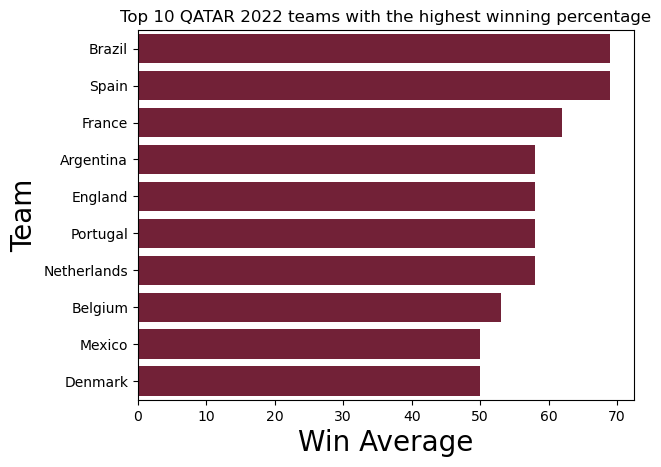

In [28]:
sns.barplot(data=rank_top10_Win,x='Average_win_Per',y='team',color="#7F1431")
plt.xticks()
plt.xlabel('Win Average', size = 20) 
plt.ylabel('Team', size = 20) 
plt.title('Top 10 QATAR 2022 teams with the highest winning percentage')

Dropping unnecessary colums.

In [29]:
# Mapping numeric values for home_team_result
final_df['home_team_result'] = final_df['home_team_result'].map({'Win':1, 'Draw':2, 'Lose':0})

In [30]:
#Dropping unnecessary colums
final_df = final_df.drop(['date', 'home_team_continent', 'away_team_continent', 'home_team_total_fifa_points', 'away_team_total_fifa_points', 'home_team_score', 'away_team_score', 'tournament', 'city', 'country', 'neutral_location', 'shoot_out'],axis=1)

In [31]:
final_df.columns

Index(['home_team', 'away_team', 'home_team_fifa_rank', 'away_team_fifa_rank',
       'home_team_result', 'home_team_goalkeeper_score',
       'away_team_goalkeeper_score', 'home_team_mean_defense_score',
       'home_team_mean_offense_score', 'home_team_mean_midfield_score',
       'away_team_mean_defense_score', 'away_team_mean_offense_score',
       'away_team_mean_midfield_score'],
      dtype='object')

In [32]:
# Change column names
final_df.rename(columns={"home_team":"Team1", "away_team":"Team2", "home_team_fifa_rank":"Team1_FIFA_RANK", 
                         "away_team_fifa_rank":"Team2_FIFA_RANK", "home_team_result":"Team1_Result", "home_team_goalkeeper_score":"Team1_Goalkeeper_Score",
                        "away_team_goalkeeper_score":"Team2_Goalkeeper_Score", "home_team_mean_defense_score":"Team1_Defense",
                        "home_team_mean_offense_score":"Team1_Offense", "home_team_mean_midfield_score":"Team1_Midfield",
                        "away_team_mean_defense_score":"Team2_Defense", "away_team_mean_offense_score":"Team2_Offense",
                        "away_team_mean_midfield_score":"Team2_Midfield"}, inplace=True)

In [33]:
final_df

,Team1,Team2,Team1_FIFA_RANK,Team2_FIFA_RANK,Team1_Result,Team1_Goalkeeper_Score,Team2_Goalkeeper_Score,Team1_Defense,Team1_Offense,Team1_Midfield,Team2_Defense,Team2_Offense,Team2_Midfield
0,Bolivia,Uruguay,59,22,1,67.0,79.0,67.0,69.0,68.0,80.0,83.0,79.0
1,Brazil,Mexico,8,14,2,86.0,79.0,86.0,86.0,85.0,77.0,79.0,78.0
2,Ecuador,Venezuela,35,94,1,71.0,68.0,71.0,75.0,75.0,72.0,75.0,73.0
4,Paraguay,Argentina,67,5,0,74.0,81.0,75.0,78.0,74.0,83.0,88.0,85.0
9,Sweden,Switzerland,4,3,0,76.0,81.0,77.0,81.0,78.0,78.0,76.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23908,Netherlands,Wales,10,18,1,81.0,74.0,85.0,83.0,84.0,75.0,73.0,78.0
23909,Poland,Belgium,26,2,0,87.0,89.0,75.0,85.0,76.0,81.0,86.0,86.0
23918,Chile,Ghana,28,60,0,79.0,74.0,76.0,77.0,78.0,76.0,76.0,78.0
23919,Japan,Tunisia,23,35,0,73.0,64.0,75.0,75.0,78.0,71.0,72.0,74.0


Exporting the training dataset.

In [34]:
final_df.to_csv("data/training.csv", index = False)

### Creating "Last Team Scores" dataset
This dataset contains the qualifications of each team on the previous FIFA date and will be used to predict the World Cup matches.

In [35]:
last_goalkeeper = df[['date', 'home_team', 'away_team', 'home_team_goalkeeper_score', 'away_team_goalkeeper_score']]
home = last_goalkeeper[['date', 'home_team', 'home_team_goalkeeper_score']].rename(columns={"home_team":"team", "home_team_goalkeeper_score":"goalkeeper_score"})
away = last_goalkeeper[['date', 'away_team', 'away_team_goalkeeper_score']].rename(columns={"away_team":"team", "away_team_goalkeeper_score":"goalkeeper_score"})
last_goalkeeper = pd.concat([home,away])

last_goalkeeper = last_goalkeeper.sort_values(['date', 'team'],ascending=[False, True])

list_2022 = ['Qatar', 'Germany', 'Denmark', 'Brazil', 'France', 'Belgium', 'Croatia', 'Spain', 'Serbia', 'England', 'Switzerland', 'Netherlands', 'Argentina', 'IR Iran', 'Korea Republic', 'Japan', 'Saudi Arabia', 'Ecuador', 'Uruguay', 'Canada', 'Ghana', 'Senegal', 'Portugal', 'Poland', 'Tunisia', 'Morocco', 'Cameroon', 'USA', 'Mexico', 'Wales', 'Australia', 'Costa Rica']

rank_qatar = last_rank[(last_rank["team"].apply(lambda x: x in list_2022))]
rank_qatar = rank_qatar.groupby('team').first().reset_index()
goal_qatar = last_goalkeeper[(last_goalkeeper["team"].apply(lambda x: x in list_2022))]
goal_qatar = goal_qatar.groupby('team').first().reset_index()
goal_qatar = goal_qatar.drop(['date'], axis = 1)
off_qatar = last_offense[(last_offense["team"].apply(lambda x: x in list_2022))]
off_qatar = off_qatar.groupby('team').first().reset_index()
off_qatar = off_qatar.drop(['date'], axis = 1)
mid_qatar = last_midfield[(last_midfield["team"].apply(lambda x: x in list_2022))]
mid_qatar = mid_qatar.groupby('team').first().reset_index()
mid_qatar = mid_qatar.drop(['date'], axis = 1)
def_qatar = last_defense[(last_defense["team"].apply(lambda x: x in list_2022))]
def_qatar = def_qatar.groupby('team').first().reset_index()
def_qatar = def_qatar.drop(['date'], axis = 1)

qatar = pd.merge(rank_qatar, goal_qatar, on = 'team')
qatar = pd.merge(qatar, def_qatar, on ='team')
qatar = pd.merge(qatar, off_qatar, on ='team')
qatar = pd.merge(qatar, mid_qatar, on ='team')

qatar['goalkeeper_score'] = round(qatar["goalkeeper_score"].transform(lambda x: x.fillna(x.mean())))
qatar['offense_score'] = round(qatar["offense_score"].transform(lambda x: x.fillna(x.mean())))
qatar['midfield_score'] = round(qatar["midfield_score"].transform(lambda x: x.fillna(x.mean())))
qatar['defense_score'] = round(qatar["defense_score"].transform(lambda x: x.fillna(x.mean())))
qatar.head(5)

,team,date,rank,goalkeeper_score,defense_score,offense_score,midfield_score
0,Argentina,2022-06-05,4,84.0,82.0,89.0,84.0
1,Australia,2022-06-13,42,77.0,72.0,72.0,74.0
2,Belgium,2022-06-14,2,89.0,81.0,86.0,86.0
3,Brazil,2022-06-06,1,89.0,85.0,86.0,86.0
4,Cameroon,2022-06-09,37,67.0,77.0,78.0,75.0


Exporting the "Last Team Scores" dataset.

In [36]:
qatar.to_csv("data/last_team_scores.csv", index = False)